**Import Library**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score

**Data preprocessing**

In [2]:
df = pd.read_csv('/content/sample_data/healthcare_dataset.csv')

categorical_text_columns = ['Medical Condition', 'Gender', 'Admission Type', 'Insurance Provider', 'Medication', 'Test Results']
df[categorical_text_columns] = df[categorical_text_columns].apply(lambda col: col.str.lower())
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
df.drop(['Name', 'Doctor', 'Hospital', 'Room Number', 'Date of Admission', 'Discharge Date'], axis=1, inplace=True)

**Remove Outliers**

In [3]:
Q1, Q3 = df['Billing Amount'].quantile([0.25, 0.75])
IQR = Q3 - Q1
df = df[(df['Billing Amount'] >= Q1 - 1.5 * IQR) & (df['Billing Amount'] <= Q3 + 1.5 * IQR)]

**Encoding Features**

In [4]:
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Insurance Provider', 'Medication', 'Test Results']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df_encoded['Billing Category'] = (df_encoded['Billing Amount'] > df_encoded['Billing Amount'].median()).astype(int)

**Splitting Features**

In [5]:
X_cls = df_encoded.drop(['Billing Amount', 'Billing Category'], axis=1)
y_cls = df_encoded['Billing Category']
X_reg = df_encoded.drop(['Billing Amount', 'Billing Category'], axis=1)
y_reg = df_encoded['Billing Amount']

**Scaling and splitting dataset**

In [6]:
scaler = StandardScaler()
X_cls[['Age', 'Length of Stay']] = scaler.fit_transform(X_cls[['Age', 'Length of Stay']])
X_reg[['Age', 'Length of Stay']] = scaler.fit_transform(X_reg[['Age', 'Length of Stay']])

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Model training

In [7]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

**Modal Evaluation**

In [8]:
results = {}
for name, model in models.items():
    model.fit(X_train_cls, y_train_cls)
    y_pred = model.predict(X_test_cls)
    results[name] = {
        'Accuracy': accuracy_score(y_test_cls, y_pred),
        'Precision': precision_score(y_test_cls, y_pred),
        'Recall': recall_score(y_test_cls, y_pred),
        'F1 Score': f1_score(y_test_cls, y_pred)
    }

results_df = pd.DataFrame(results).T
print("Model Performance Summary:")
print(results_df)

Model Performance Summary:
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.504865   0.507889  0.484588  0.495965
Decision Tree        0.543514   0.545861  0.547133  0.546496
Random Forest        0.567297   0.573371  0.544086  0.558345
Gradient Boosting    0.501351   0.504163  0.488351  0.496131
SVM                  0.513333   0.515984  0.514875  0.515429
KNN                  0.517568   0.520488  0.512186  0.516304


**Selecting Best Model**

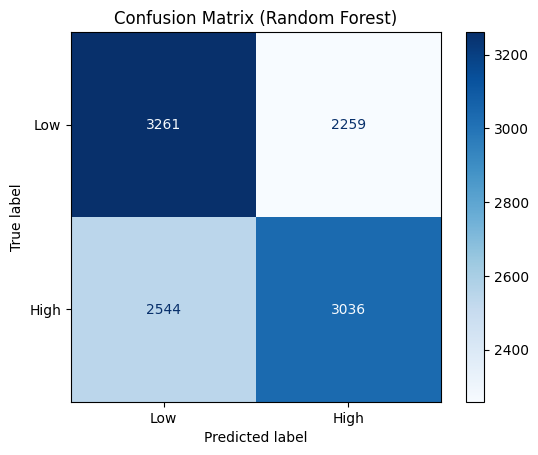

In [9]:
best_model_name = results_df['F1 Score'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_cls)

cm = confusion_matrix(y_test_cls, y_pred_best)
ConfusionMatrixDisplay(cm, display_labels=['Low', 'High']).plot(cmap='Blues')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.show()

**Train Regression Model**

In [10]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = regressor.predict(X_test_reg)
print("\nRegression Model Evaluation:")
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))


Regression Model Evaluation:
R2 Score: 0.03380665890263079
RMSE: 13863.078053434665


**Visualization**

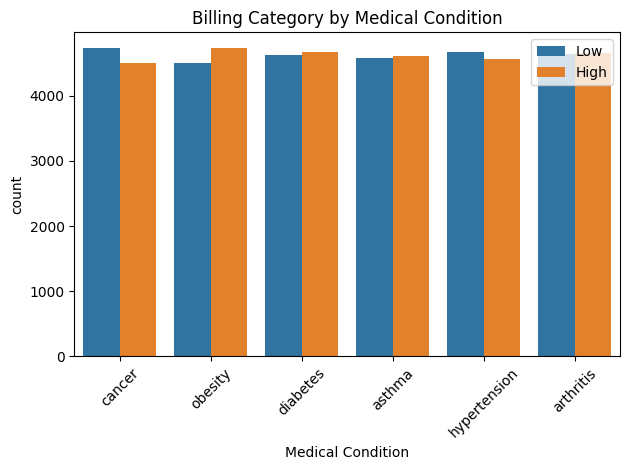

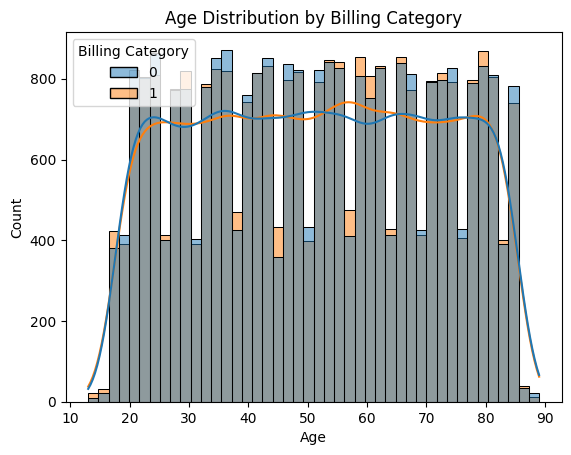

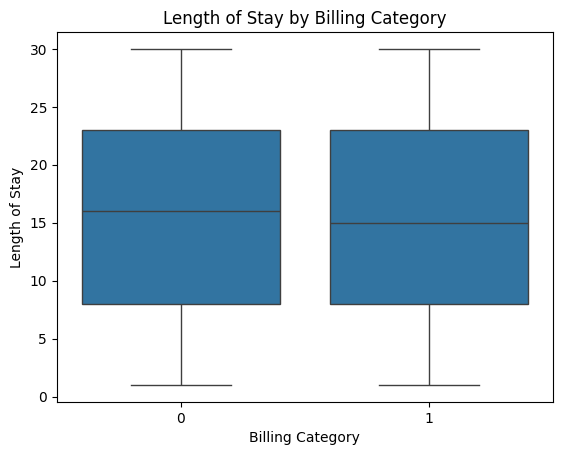

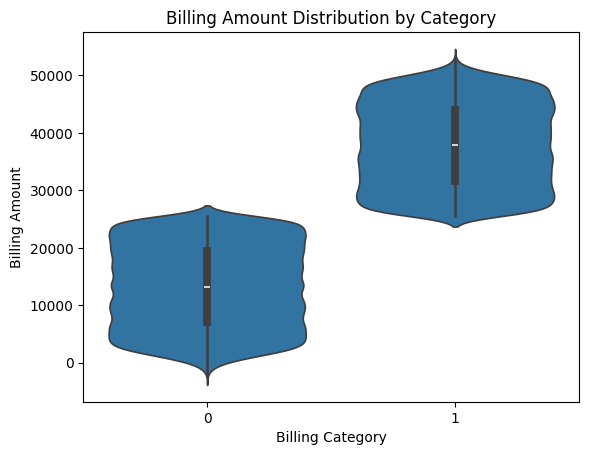

In [11]:
df['Billing Category'] = df_encoded['Billing Category'].values

# Count Plot
sns.countplot(x='Medical Condition', hue='Billing Category', data=df)
plt.title('Billing Category by Medical Condition')
plt.xticks(rotation=45)
plt.legend(['Low', 'High'])
plt.tight_layout()
plt.show()

# Histogram
sns.histplot(data=df, x='Age', hue='Billing Category', kde=True)
plt.title('Age Distribution by Billing Category')
plt.show()

# Boxplot
sns.boxplot(x='Billing Category', y='Length of Stay', data=df)
plt.title('Length of Stay by Billing Category')
plt.show()

# Violinplot
sns.violinplot(x='Billing Category', y='Billing Amount', data=df)
plt.title('Billing Amount Distribution by Category')
plt.show()

**Predicting Category**

In [12]:
def predict_billing_category(model, scaler, input_data, feature_columns):
    input_df = pd.DataFrame([input_data])
    input_encoded = pd.get_dummies(input_df).reindex(columns=feature_columns, fill_value=0)
    input_encoded[['Age', 'Length of Stay']] = scaler.transform(input_encoded[['Age', 'Length of Stay']])
    prediction = model.predict(input_encoded)
    return 'High' if prediction[0] == 1 else 'Low'

**Predicting Amount**

In [13]:
def predict_billing_amount(model, scaler, input_data, feature_columns):
    input_df = pd.DataFrame([input_data])
    input_encoded = pd.get_dummies(input_df).reindex(columns=feature_columns, fill_value=0)
    input_encoded[['Age', 'Length of Stay']] = scaler.transform(input_encoded[['Age', 'Length of Stay']])
    prediction = model.predict(input_encoded)
    return round(prediction[0], 2)

**User Input**

In [14]:
name = input('Enter Name: ')
user_input = {
    'Age': int(input('Enter Age: ')),
    'Gender': input('Enter Gender: ').lower(),
    'Blood Type': input('Enter Blood Type (A+/A-/B+/B-/AB+/AB-/O+/O-): ').upper(),
    'Medical Condition': input('Enter Medical Condition (e.g., diabetes, asthma): ').lower(),
    'Admission Type': input('Enter Admission Type (elective/emergency/urgent): ').lower(),
    'Insurance Provider': input('Enter Insurance Provider (e.g., medicare, cigna): ').lower(),
    'Medication': input('Enter Medication (e.g., aspirin, penicillin): ').lower(),
    'Test Results': input('Enter Test Results (normal/abnormal/inconclusive): ').lower(),
    'Length of Stay': int(input('Enter Length of Stay (in days): '))
}

category_prediction = predict_billing_category(best_model, scaler, user_input, X_cls.columns)
amount_prediction = predict_billing_amount(regressor, scaler, user_input, X_reg.columns)

print(f"\nPatient '{name}', the predicted billing category is: {category_prediction}.")
print(f"The estimated billing amount is: ₹{amount_prediction}")

Enter Name: Nikhil
Enter Age: 20
Enter Gender: Male
Enter Blood Type (A+/A-/B+/B-/AB+/AB-/O+/O-): A+
Enter Medical Condition (e.g., diabetes, asthma): diabetes
Enter Admission Type (elective/emergency/urgent): elective
Enter Insurance Provider (e.g., medicare, cigna): medicare
Enter Medication (e.g., aspirin, penicillin): penicillin
Enter Test Results (normal/abnormal/inconclusive): normal
Enter Length of Stay (in days): 10

Patient 'Nikhil', the predicted billing category is: Low.
The estimated billing amount is: ₹17333.88
